In [1]:
import iris
import numpy as np
import matplotlib.pyplot as plt
import iris.plot as iplt
import cartopy.crs as ccrs
from iris.coord_categorisation import add_day_of_year,add_hour,add_year

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from six.moves import range

import os
os.chdir("/home/548/eh6215/Desktop/python/ASoP/ASoP-Coherence")
import asop_coherence

In [2]:
params = {"BARPAC-M": {'dt':3600*3, 'dx':25, 'dy':25, 'legend_name':'BARPAC-M', 'name':'BARPAC-M', 'region':[-45,-30,140,155], 'box_size':200, 'color':'tab:red',   'region_size':9, 'lag_length':6, 'autocorr_length':60*60*24*5},
          "BARPAC-T": {'dt':3600*3, 'dx':25, 'dy':25, 'legend_name':'BARPAC-T', 'name':'BARPAC-T', 'region':[-30,-10,140,155], 'box_size':200, 'color':'tab:blue', 'region_size':9, 'lag_length':6, 'autocorr_length':60*60*24*5},
          "BARPAR-M": {'dt':3600*3, 'dx':25, 'dy':25, 'legend_name':'BARPAR-M', 'name':'BARPAR-M', 'region':[-45,-30,140,155], 'box_size':200, 'color':'tab:green',  'region_size':9, 'lag_length':6, 'autocorr_length':60*60*24*5},
          "BARPAR-T": {'dt':3600*3, 'dx':25, 'dy':25, 'legend_name':'BARPAR-T', 'name':'BARPAR-T', 'region':[-30,-10,140,155], 'box_size':200, 'color':'tab:orange', 'region_size':9, 'lag_length':6, 'autocorr_length':60*60*24*5},
          "TRMM-M": {'dt':3600*3, 'dx':25, 'dy':25, 'legend_name':'TRMM-M', 'name':'BARPAR-M', 'region':[-45,-30,140,155], 'box_size':200, 'color':'tab:green',  'region_size':9, 'lag_length':6, 'autocorr_length':60*60*24*5},
          "TRMM-T": {'dt':3600*3, 'dx':25, 'dy':25, 'legend_name':'TRMM-T', 'name':'BARPAR-T', 'region':[-30,-10,140,155], 'box_size':200, 'color':'tab:orange', 'region_size':9, 'lag_length':6, 'autocorr_length':60*60*24*5}}

bins=[0,0.5,1,2,4,6,9,12,16,20,25,30,40,60,90,130,180,2e20]
bins=[0,0.125,0.25,0.5,1,2,4,8,16,32,64,128,256,2e20]
bins = [0]+list(np.exp(np.arange(-1,8,0.5)))

In [6]:
path = "/short/tp28/eh6215/ESCI/3hr_BARPAC-T/"
oned_hist,twod_hist,grid_corr={},{},{}
data = {"BARPAC-M":iris.cube.CubeList(),"BARPAC-T":iris.cube.CubeList(),"BARPA-E":iris.cube.CubeList()}

In [7]:
for j,name in enumerate(["BARPAC-M","BARPAC-T","BARPA-E"]):
    for year in list(range(1991,2014)):
      if year not in [1999,2009,1996]:
        print(year)
        tmp=iris.load_cube(path+"regrid_%s_%d.nc"%(name,year))[:720]
        tmp.data=tmp.data.filled(0)
        try:
            add_day_of_year(tmp,'time','doyr')
        except ValueError:
            tmp.remove_coord('forecast_period')
            tmp.remove_coord('forecast_reference_time')
        tmp.coord('doyr').points= np.arange(0,90,1/8)#+tmp.coord('hour').points/24
        tmp.remove_coord('time')
        yrcoord = iris.coords.AuxCoord(year,units='years',long_name='year')
        tmp.add_aux_coord(yrcoord)
        iris.util.promote_aux_coord_to_dim_coord(tmp,'doyr')
        tmp.coord('doyr').rename('time')
        data[name].append(tmp)
    iris.util.equalise_attributes(data[name])
    data[name] = data[name].merge_cube()

1991
1992
1993
1994
1995
1997
1998
2000
2001
2002
2003
2004
2005
2006
2007
2008
2010
2011
2012
2013
1991
1992
1993
1994
1995
1997
1998
2000
2001
2002
2003
2004
2005
2006
2007
2008
2010
2011
2012
2013
1991
1992
1993
1994
1995
1997
1998
2000
2001
2002
2003
2004
2005
2006
2007
2008
2010
2011
2012
2013


In [26]:
for region in ['T']:
        cy = {'M':iris.Constraint(latitude=lambda x:-45<=x<=-30),"T":iris.Constraint(latitude=lambda x:-30<=x<=-10)}[region]
        cx = iris.Constraint(longitude=lambda x: 140<=x<=155)
        #oned_hist['BARPAR-'+region],twod_hist['BARPAR-'+region] = asop_coherence.compute_histogram(data['BARPA-E'].extract(cx&cy),bins)
        oned_hist['BARPAC-'+region],twod_hist['BARPAC-'+region] = asop_coherence.compute_histogram(data['BARPAC-'+region].extract(cx&cy),bins)
        

#   for region in ['M','T']:
#       grid_corr['BARPAR-'+region] = asop_coherence.compute_equalgrid_corr(data['BARPA-E'].extract(cx&cy),params['BARPAR-'+region])
#       grid_corr['BARPAC-'+region] = asop_coherence.compute_equalgrid_corr(data['BARPAC-M'].extract(cx&cy),params['BARPAC-'+region])

---> Computing 2D histogram


In [24]:
  
def plot_histogram(oned_hist,twod_hist,model_dict,bins,fig,ax,i,title=True,colorbar=True,wk_dir='.',ext='.ps'):    
    nbins = np.size(oned_hist)
    hist_con_levs=[1e-5,2e-5,4e-5,7e-5,1e-4,2e-4,4e-4,7e-4,1e-3,2e-3,4e-3,7e-3,1e-2,2e-2,4e-2,7e-2,1e-1]
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    cmap = plt.cm.get_cmap("viridis_r")
    norm = BoundaryNorm(hist_con_levs,ncolors=cmap.N,clip=True)
    contour = ax.pcolormesh(np.arange(nbins+1),np.arange(nbins+1),twod_hist,cmap=cmap,norm=norm)
    if colorbar == True:
        cbar = fig.colorbar(contour,orientation='horizontal',ticks=hist_con_levs)
        cbar.ax.set_xlabel('Probability',fontsize=18)
        cbar.ax.set_xticklabels(['1e-5','2e-5','4e-5','7e-5','1e-4','2e-4','4e-4','7e-4','1e-3','2e-3','4e-3','7e-3','1e-2','2e-2','4e-2','7e-2','1e-1'])
    ax.set_xlabel('Precipitation at time t (mm day$^{-1}$)',fontsize=16)
    ticklabels=['< '+str(bins[1])]
    for bin in range(1,nbins):
        ticklabels.append(str(bins[bin]))
    ticklabels.append(' > '+str(bins[nbins-1]))
    ax.set_xticks(np.arange(nbins+1))
    ax.set_xticklabels(ticklabels,fontsize=10,rotation=45)
    ax.set_yticks(np.arange(nbins+1))
    ax.set_yticklabels(ticklabels,fontsize=10)
    if title == True:
        title_string = '2D histogram for '+model_dict['legend_name']
        if 'time_desc' in model_dict:
            title_string = title_string+' '+model_dict['time_desc']
        if 'grid_desc' in model_dict:
            title_string = title_string+' '+model_dict['grid_desc']
        if 'region_desc' in model_dict:
            title_string = title_string+' - '+model_dict['region_desc']
        title_string = title_string + ' data'
        ax.set_title(title_string)
    ax.axis([0,nbins,0,nbins])
    ax.set_xlim(xmin=0,xmax=nbins)
    ax2 = ax.twinx()
    ax2.plot(np.arange(nbins)+0.5,oned_hist,'k--',marker='o',markersize=8)
    ax2.set_yscale('log')#,nonposy='clip')
    ax2.set_ylim(ymin=0.0009,ymax=1.0)
    if i%2==0:
        ax.set_ylabel('Precipitation at time t+1 (mm day$^{-1}$)',fontsize=16)
    else:
        ax2.set_ylabel('Probability of precipitation in bin',fontsize=14)
    ax2.set_yticks([1e-3,1.4e-3,2e-3,3e-3,4.5e-3,7e-3,1e-2,1.4e-2,2e-2,3e-2,4.5e-2,7e-2,1e-1,1.4e-1,2e-1,3e-1,4.5e-1,7e-1,1])
    ax2.set_yticklabels(['1.0e-3','1.4e-3','2.0e-3','3.0e-3','4.5e-3','7.0e-3','1.0e-2','1.4e-2','2.0e-2','3.0e-2','4.5e-2',
                         '7.0e-2','1.0e-1','1.4e-1','2.0e-1','3.0e-1','4.5e-1','7.0e-1','1.0e0'],fontsize=10)
    ax2.set_xlim(xmin=0,xmax=nbins)
    plot_name=wk_dir+'/asop_coherence.'+model_dict['name']
    if 'grid_type' in model_dict:
        plot_name=plot_name+'_'+model_dict['grid_type']
    if 'time_type' in model_dict:
        plot_name=plot_name+'_'+model_dict['time_type']
    if 'region_name' in model_dict:
        plot_name=plot_name+'_'+model_dict['region_name'].replace(" ","_")
    plot_name=plot_name+'_precip_twodpdf'+ext
    return contour

In [8]:
path = "/short/tp28/eh6215/ESCI/3hr_BARPAC-T/"

data['trmm'] = iris.cube.CubeList()
for year in list(range(1998,2009)):
    for name in ['trmm']:
        print(year)
        tmp=iris.load_cube(path+"%s_%d.nc"%(name,year))[:720]
        try:
            add_day_of_year(tmp,'time','doyr')
        except ValueError:
            1
        tmp.coord('doyr').points= np.arange(0,90,1/8)#+tmp.coord('hour').points/24
        tmp.remove_coord('time')
        yrcoord = iris.coords.AuxCoord(year,units='years',long_name='year')
        tmp.add_aux_coord(yrcoord)
        iris.util.promote_aux_coord_to_dim_coord(tmp,'doyr')
        tmp.coord('doyr').rename('time')
        data[name].append(tmp)

iris.util.equalise_attributes(data[name])
data[name] = data[name].merge_cube()
print(data[name].summary(shorten=True))

1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
precipitation (mm/hr) / (unknown)   (year: 11; time: 720; latitude: 140; longitude: 60)


In [21]:
for region in ['M','T']:
        cy = {'M':iris.Constraint(latitude=lambda x:-45<=x<=-30),"T":iris.Constraint(latitude=lambda x:-30<=x<=-10)}[region]
        cx = iris.Constraint(longitude=lambda x: 140<=x<=155)
        oned_hist['TRMM-'+region],twod_hist['TRMM-'+region] = asop_coherence.compute_histogram(data['trmm'].extract(cx&cy)*24,bins)

---> Computing 2D histogram
---> Computing 2D histogram


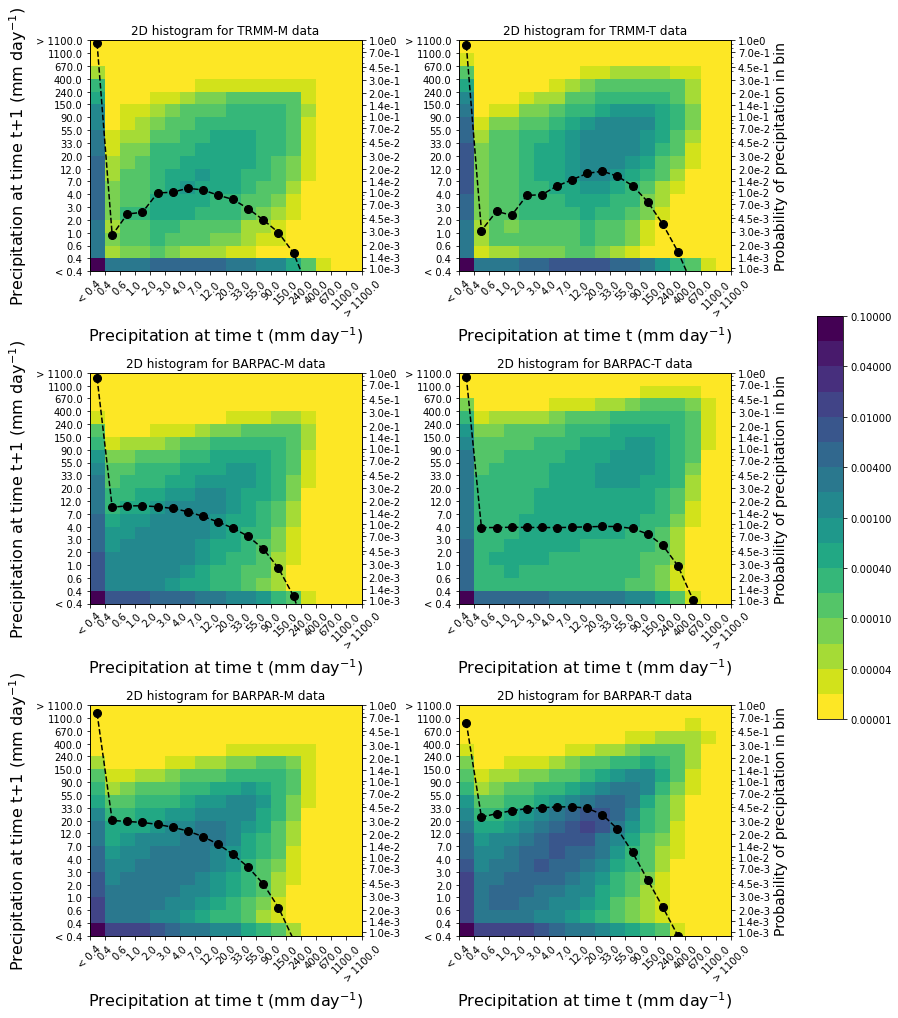

In [27]:
fig = plt.figure(figsize=(12,14))
ax =[]
for i,key in enumerate(['TRMM-M','TRMM-T','BARPAC-M','BARPAC-T','BARPAR-M', 'BARPAR-T']):
    ax.append(plt.subplot(3,2,i+1))
    a=plot_histogram(oned_hist[key],twod_hist[key],params[key],[0]+[np.round(x,-1*int(np.log10(x)-1)) for x in bins[1:]],fig,ax[-1],i,colorbar=False)

fig.tight_layout()
fig.subplots_adjust(right=0.85)
cax = fig.add_axes([0.95,0.3,0.03,0.4])
fig.colorbar(a,cax=cax)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'doyr'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'hour'.
  warnings.warn(msg.format(self.na

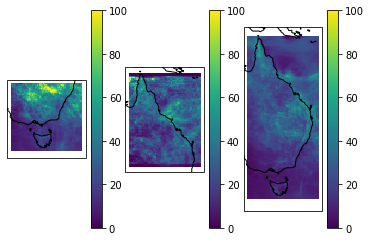

In [17]:
for i,name in enumerate(data):
    ax=plt.subplot(1,3,i+1,projection=ccrs.PlateCarree())
    iplt.pcolormesh(data[name].collapsed('time',iris.analysis.MEAN)*{'BARPAC-M':3,'BARPAC-T':1,'BARPA-E':3}[name],vmin=0,vmax=100)
    plt.colorbar()
    ax.coastlines()

In [14]:
data

{'BARPAC-M': <iris 'Cube' of stratiform_rainfall_flux / (mm/day) (time: 728; latitude: 60; longitude: 60)>,
 'BARPAC-T': <iris 'Cube' of stratiform_rainfall_flux / (mm/day) (time: 728; latitude: 80; longitude: 60)>,
 'BARPA-E': <iris 'Cube' of precipitation_flux / (mm/day) (time: 728; latitude: 140; longitude: 60)>}

In [30]:
np.exp(np.arange(-4,9,0.5))

array([1.83156389e-02, 3.01973834e-02, 4.97870684e-02, 8.20849986e-02,
       1.35335283e-01, 2.23130160e-01, 3.67879441e-01, 6.06530660e-01,
       1.00000000e+00, 1.64872127e+00, 2.71828183e+00, 4.48168907e+00,
       7.38905610e+00, 1.21824940e+01, 2.00855369e+01, 3.31154520e+01,
       5.45981500e+01, 9.00171313e+01, 1.48413159e+02, 2.44691932e+02,
       4.03428793e+02, 6.65141633e+02, 1.09663316e+03, 1.80804241e+03,
       2.98095799e+03, 4.91476884e+03])

In [54]:

[np.round(x,-1*int(np.log10(x)-2)) for x in bins]

[0.018,
 0.03,
 0.05,
 0.082,
 0.14,
 0.22,
 0.37,
 0.61,
 1.0,
 1.6,
 2.7,
 4.5,
 7.4,
 12.0,
 20.0,
 33.0,
 55.0,
 90.0,
 148.0,
 245.0,
 403.0,
 665.0,
 1100.0,
 1810.0,
 2980.0,
 4910.0]

In [47]:
np.log10(bins)

array([-1.73717793, -1.52003069, -1.30288345, -1.0857362 , -0.86858896,
       -0.65144172, -0.43429448, -0.21714724,  0.        ,  0.21714724,
        0.43429448,  0.65144172,  0.86858896,  1.0857362 ,  1.30288345,
        1.52003069,  1.73717793,  1.95432517,  2.17147241,  2.38861965,
        2.60576689,  2.82291413,  3.04006137,  3.25720861,  3.47435586,
        3.6915031 ])

In [ ]:
np.round(-0.1,-1)

array([[8.33594758e-01, 2.51750874e-03, 4.64288095e-03, 5.07555645e-03,
        8.35434018e-03, 8.23447738e-03, 7.57688858e-03, 5.85066926e-03,
        4.54523661e-03, 3.52513591e-03, 2.33118542e-03, 1.69133242e-03,
        1.09143369e-03, 5.21744283e-04, 1.27658762e-04, 1.30582245e-05,
        1.94898873e-06, 0.00000000e+00],
       [2.55512422e-03, 1.09143369e-04, 1.36624110e-04, 1.23955683e-04,
        1.98796850e-04, 1.34870020e-04, 1.22006694e-04, 9.76443353e-05,
        7.42564705e-05, 5.00890103e-05, 4.30726509e-05, 2.39725614e-05,
        2.31929659e-05, 9.74494364e-06, 2.92348309e-06, 0.00000000e+00,
        1.94898873e-07, 0.00000000e+00],
       [4.60156239e-03, 1.34675121e-04, 2.96636084e-04, 2.62723681e-04,
        4.49826598e-04, 2.97220781e-04, 2.74612512e-04, 1.96847862e-04,
        1.50461930e-04, 1.18693414e-04, 7.64003581e-05, 5.69104709e-05,
        3.74205836e-05, 2.39725614e-05, 7.60105604e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [5.048

In [9]:

def parameters():

    """
    Parameters that control the size of arrays used in other functions.
    """

    max_box_distance=100
    max_timesteps=100
    max_boxes=200
    return(max_box_distance,max_boxes,max_timesteps)

def compute_autocorr(precip,model_dict):
    print('---> Computing auto-correlations')
    nlon=len(precip.coord('longitude').points)
    nlat=len(precip.coord('latitude').points)
    autocorr_length = model_dict['autocorr_length']
    max_box_distance,max_boxes,max_timesteps = parameters()
    # +1 to account for lag-zero correlation
    autocorr_nt = np.int64(autocorr_length//(model_dict['dt']))+1
    time_max = autocorr_nt
    time_correlations = np.zeros(max_timesteps)
    n_tot = np.zeros(max_timesteps)
    print('----> Info: Computing auto-correlations for '+str(autocorr_nt)+' lags. Corrected.')
    if autocorr_nt > max_timesteps:
        raise Exception('Error: Number of lags for auto-correlation exceeds maximum ('+str(max_timesteps)+').  Increase parameter max_timesteps in code or reduce autocorrelation length.')
    for lon in range(nlon):
        for lat in range(nlat):
            for lag in range(autocorr_nt):
                this_precip = precip.data[:,lat,lon]
                corr = np.corrcoef(this_precip,np.roll(this_precip,lag,0))[1,0]
                if not np.isnan(corr):
                    time_correlations[lag] = time_correlations[lag] + corr
                    n_tot[lag] +=1

    time_correlations = time_correlations / n_tot
    return(time_correlations,time_max)



In [8]:
time_corr,time_max = [0,0,0,0,0,0],[0,0,0,0,0,0]
i=0
for region in ['M','T']:
        cy = {'M':iris.Constraint(latitude=lambda x:-45<=x<=-30),"T":iris.Constraint(latitude=lambda x:-30<=x<=-10)}[region]
        cx = iris.Constraint(longitude=lambda x: 140<=x<=155)
        time_corr[i],time_max[i] = compute_autocorr(data['BARPA-E'].extract(cx&cy),params['BARPAR-'+region])
        print(time_corr[i])
        i+=1
        time_corr[i],time_max[i] = compute_autocorr(data['BARPAC-'+region].extract(cx&cy),params['BARPAC-'+region])
        print(time_corr[i])
        i+=1  
        time_corr[i],time_max[i] = compute_autocorr(data['trmm'].extract(cx&cy),params['TRMM-'+region])
        print(time_corr[i])
        i+=1  
                
        

---> Computing auto-correlations
----> Info: Computing auto-correlations for 41 lags. Corrected.


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/local/zv2/eh6215/tmp/ipykernel_2824418/604485262.py:35: RuntimeWarning: invalid value encountered in true_divide
  time_correlations = time_correlations / n_tot


[ 1.          0.45937811  0.21984294  0.1418188   0.10517829  0.08983878
  0.07424556  0.0671858   0.05507729  0.03572508  0.02123467  0.01100232
  0.00310438 -0.00137024 -0.00330825 -0.00331064 -0.00166048 -0.00412844
 -0.01016106 -0.01549322 -0.01899199 -0.01900067 -0.01829205 -0.01656093
 -0.01820326 -0.02295565 -0.02692527 -0.02853106 -0.02953902 -0.02884288
 -0.02714348 -0.025126   -0.02303144 -0.02331816 -0.02381754 -0.02338055
 -0.02164565 -0.01777165 -0.01493772 -0.01214821 -0.0106311          nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan   

/local/zv2/eh6215/tmp/ipykernel_2824418/604485262.py:35: RuntimeWarning: invalid value encountered in true_divide
  time_correlations = time_correlations / n_tot


[ 1.00000000e+00  1.41430648e-02  6.22817661e-03  3.22368513e-03
  1.96930213e-03  1.47341616e-03 -5.88631609e-05 -9.03084456e-04
  1.32109145e-01 -3.38271510e-03 -3.76810785e-03 -4.06002398e-03
 -3.85604427e-03 -3.67456305e-03 -3.56517443e-03 -3.73889855e-03
 -4.13155586e-03 -4.48837132e-03 -4.30462030e-03 -4.12406541e-03
 -3.37509430e-03 -2.05662743e-03 -2.31391038e-03 -3.53067258e-03
  1.02022078e-01 -3.84009309e-03 -3.69742182e-03 -4.06630020e-03
 -4.03363837e-03 -3.78315571e-03 -4.25887530e-03 -3.79286955e-03
  1.02039993e-01 -3.73671871e-03 -3.77662800e-03 -3.84121802e-03
 -4.09897059e-03 -4.24869863e-03 -4.37753201e-03 -4.68187680e-03
 -4.85238618e-03             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan         

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/local/zv2/eh6215/tmp/ipykernel_2824418/604485262.py:35: RuntimeWarning: invalid value encountered in true_divide
  time_correlations = time_correlations / n_tot


[ 1.00000000e+00  3.93988090e-01  1.63010452e-01  1.05013482e-01
  8.13292937e-02  7.06370765e-02  6.87192575e-02  6.97258847e-02
  6.64997192e-02  5.14009618e-02  3.43914948e-02  2.37382944e-02
  1.76237081e-02  1.44120640e-02  1.33969018e-02  1.50753404e-02
  1.64100234e-02  1.34473755e-02  9.59181535e-03  8.32383412e-03
  7.91045259e-03  5.90947284e-03  5.70387987e-03  8.08642121e-03
  9.62312752e-03  5.78698608e-03  1.14167013e-03 -2.34868306e-03
 -4.23298718e-03 -4.83081563e-03 -4.46637875e-03 -2.12274257e-03
 -3.87149528e-04 -2.28762286e-03 -5.90680589e-03 -6.99883876e-03
 -6.09204277e-03 -4.23558884e-03 -3.22442547e-03 -1.40006744e-03
 -1.46974894e-03             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan         

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/local/zv2/eh6215/tmp/ipykernel_2824418/604485262.py:35: RuntimeWarning: invalid value encountered in true_divide
  time_correlations = time_correlations / n_tot


IndexError: list assignment index out of range

In [ ]:
for region in ['M','T']:
    tmp = compute_autocorr(data['trmm'].extract(cx&cy),params['TRMM-'+region])
    time_corr.append(tmp[0])
    time_max.append(tmp[1])


--> Plotting correlations vs. time for all models.
[   0.  180.  360.  540.  720.  900. 1080. 1260. 1440. 1620. 1800. 1980.
 2160. 2340. 2520. 2700. 2880. 3060. 3240. 3420. 3600. 3780. 3960. 4140.
 4320. 4500. 4680. 4860. 5040. 5220. 5400. 5580. 5760. 5940. 6120. 6300.
 6480. 6660. 6840. 7020. 7200.] [ 1.          0.45937811  0.21984294  0.1418188   0.10517829  0.08983878
  0.07424556  0.0671858   0.05507729  0.03572508  0.02123467  0.01100232
  0.00310438 -0.00137024 -0.00330825 -0.00331064 -0.00166048 -0.00412844
 -0.01016106 -0.01549322 -0.01899199 -0.01900067 -0.01829205 -0.01656093
 -0.01820326 -0.02295565 -0.02692527 -0.02853106 -0.02953902 -0.02884288
 -0.02714348 -0.025126   -0.02303144 -0.02331816 -0.02381754 -0.02338055
 -0.02164565 -0.01777165 -0.01493772 -0.01214821 -0.0106311 ]
[   0.  180.  360.  540.  720.  900. 1080. 1260. 1440. 1620. 1800. 1980.
 2160. 2340. 2520. 2700. 2880. 3060. 3240. 3420. 3600. 3780. 3960. 4140.
 4320. 4500. 4680. 4860. 5040. 5220. 5400. 5580. 576

/home/548/eh6215/Desktop/python/ASoP/ASoP-Coherence/asop_coherence.py:1126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(11)*tmax//10,fontsize=16)
/home/548/eh6215/Desktop/python/ASoP/ASoP-Coherence/asop_coherence.py:1127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(np.arange(12)*0.1-0.1,1),fontsize=16)


ValueError: operands could not be broadcast together with shapes (6,) (4,) 

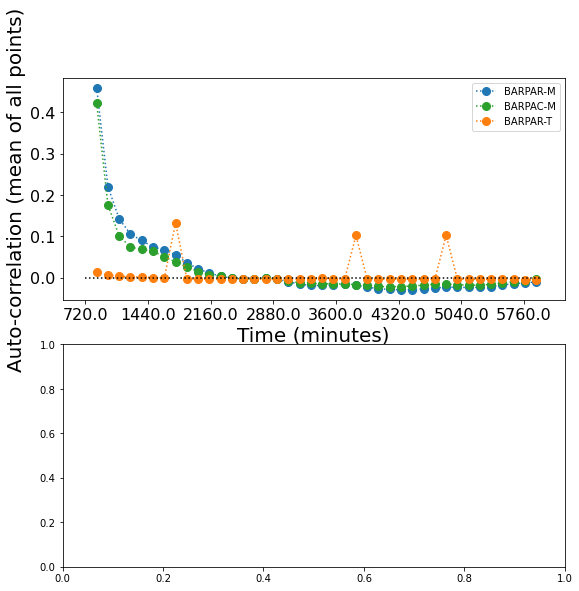

In [13]:
plt.figure(figsize=(9,9))
ax=plt.subplot(211)
asop_coherence.plot_autocorr(np.array(time_corr)[[0,1,3]],np.array(time_max)[[0,1,3]],ax,colors=['tab:blue','tab:green','tab:orange','tab:red'][:3],dt=np.array([3,3,3,3])[:3]*3600,legend_names=['BARPAR-M', 'BARPAC-M', 'BARPAR-T', 'BARPAC-T'][:3],set_desc='satobs')
ax.legend()
ax=plt.subplot(212)
asop_coherence.plot_autocorr(np.array(time_corr),np.array(time_max),ax,colors=['tab:blue','tab:green','tab:orange','tab:red'],dt=np.array([3,3,3,3])*3600,legend_names=['BARPAR-M', 'BARPAC-M', 'BARPAR-T', 'BARPAC-T'],set_desc='satobs')
ax.legend()


In [52]:
oned_hist.keys()

dict_keys(['BARPAR-M', 'BARPAC-M', 'BARPAR-T', 'BARPAC-T'])

In [19]:
time_corr

[array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [15]:
data

{'BARPAC-M': <iris 'Cube' of stratiform_rainfall_flux / (mm/day) (year: 11; time: 720; latitude: 60; longitude: 60)>,
 'BARPAC-T': <iris 'Cube' of stratiform_rainfall_flux / (mm/day) (year: 11; time: 720; latitude: 80; longitude: 60)>,
 'BARPA-E': <iris 'Cube' of precipitation_flux / (mm/day) (year: 11; time: 720; latitude: 140; longitude: 60)>,
 'trmm': <iris 'Cube' of precipitation (mm/hr) / (unknown) (year: 11; time: 720; latitude: 140; longitude: 60)>}

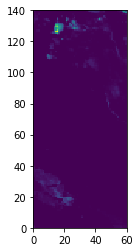

In [15]:
plt.subplot(111,aspect=1)
plt.pcolormesh(data['trmm'].data[532])

In [11]:
[time_corr[i][2] for i in range(6)]

[0.21984293803733043,
 0.17532927787828473,
 0.17532927787828473,
 0.006228176610421481,
 0.3400254778371114,
 0.1630104517397334]

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'hour'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))
/g/d

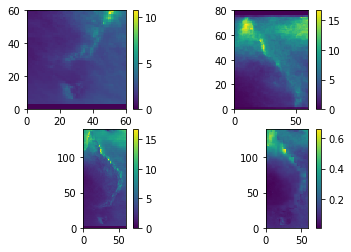

In [31]:
for i,cube in enumerate(data):
    plt.subplot(2,2,i+1,aspect=1)
    plt.pcolormesh(data[cube].collapsed(['time','year'],iris.analysis.MEAN).data)
    plt.colorbar()

In [44]:
#corr_map  = {}
for region in ['M','T']:
    cy = {'M':iris.Constraint(latitude=lambda x:-45<=x<=-30),"T":iris.Constraint(latitude=lambda x:-30<=x<=-10)}[region]
    cx = iris.Constraint(longitude=lambda x: 140<=x<=155)
    for i in range(11):
        if i==0:
            corr_map["BARPAC-"+region] = list(asop_coherence.compute_equalgrid_corr(data['BARPAC-'+region][i].extract(cx&cy),params['BARPAC-'+region]))
            corr_map["BARPAR-"+region] = list(asop_coherence.compute_equalgrid_corr(data['BARPA-E'][i].extract(cx&cy),params['BARPAR-'+region]) )
            corr_map["TRMM-"+region]  =  list(asop_coherence.compute_equalgrid_corr(data['trmm'][i].extract(cx&cy)*24,params['TRMM-'+region]))
        else:
            tmp1 = asop_coherence.compute_equalgrid_corr(data['BARPAC-'+region][i].extract(cx&cy),params['BARPAC-'+region])
            tmp2 = asop_coherence.compute_equalgrid_corr(data['BARPA-E'][i].extract(cx&cy),params['BARPAR-'+region]) 
            tmp3 = asop_coherence.compute_equalgrid_corr(data['trmm'][i].extract(cx&cy)*24,params['TRMM-'+region])
            for i in [0,1,2,4]:
                corr_map["BARPAC-"+region][i] =tmp1[i] + corr_map["BARPAC-"+region][i]
                corr_map["BARPAR-"+region][i] =tmp2[i] + corr_map["BARPAR-"+region][i]
                corr_map["TRMM-"+region][i] =tmp3[i] + corr_map["TRMM-"+region][i]

---> Computing correlations for 9x9 sub-regions
----> Info: Size of domain in native gridpoints: 60 longitude x 60 latitude.


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


----> Info: There are 36 9x9 sub-regions in your input data.
---> Computing correlations for 9x9 sub-regions
----> Info: Size of domain in native gridpoints: 60 longitude x 61 latitude.
----> Info: There are 36 9x9 sub-regions in your input data.
---> Computing correlations for 9x9 sub-regions
----> Info: Size of domain in native gridpoints: 60 longitude x 60 latitude.
----> Info: There are 36 9x9 sub-regions in your input data.
---> Computing correlations for 9x9 sub-regions
----> Info: Size of domain in native gridpoints: 60 longitude x 60 latitude.
----> Info: There are 36 9x9 sub-regions in your input data.
---> Computing correlations for 9x9 sub-regions
----> Info: Size of domain in native gridpoints: 60 longitude x 61 latitude.
----> Info: There are 36 9x9 sub-regions in your input data.
---> Computing correlations for 9x9 sub-regions
----> Info: Size of domain in native gridpoints: 60 longitude x 60 latitude.
----> Info: There are 36 9x9 sub-regions in your input data.
---> Comp

In [48]:
for i in [0,1,2,4]:
  for region in ['M','T']:
    corr_map["BARPAC-"+region][i] =corr_map["BARPAC-"+region][i]/ 11.0
    corr_map["BARPAR-"+region][i] =  corr_map["BARPAR-"+region][i]/11.0
    #corr_map["TRMM-"+region][i] =  corr_map["TRMM-"+region][i]/ 11.0

---> Plotting correlation maps for 9x9 sub-regions
---> Plotting lag vs. distance diagram
(6, 10)
---> Plotting correlation maps for 9x9 sub-regions
---> Plotting lag vs. distance diagram
(6, 10)
---> Plotting correlation maps for 9x9 sub-regions
---> Plotting lag vs. distance diagram
(6, 10)
---> Plotting correlation maps for 9x9 sub-regions
---> Plotting lag vs. distance diagram
(6, 10)
---> Plotting correlation maps for 9x9 sub-regions
---> Plotting lag vs. distance diagram
(6, 10)
---> Plotting correlation maps for 9x9 sub-regions
---> Plotting lag vs. distance diagram
(6, 10)


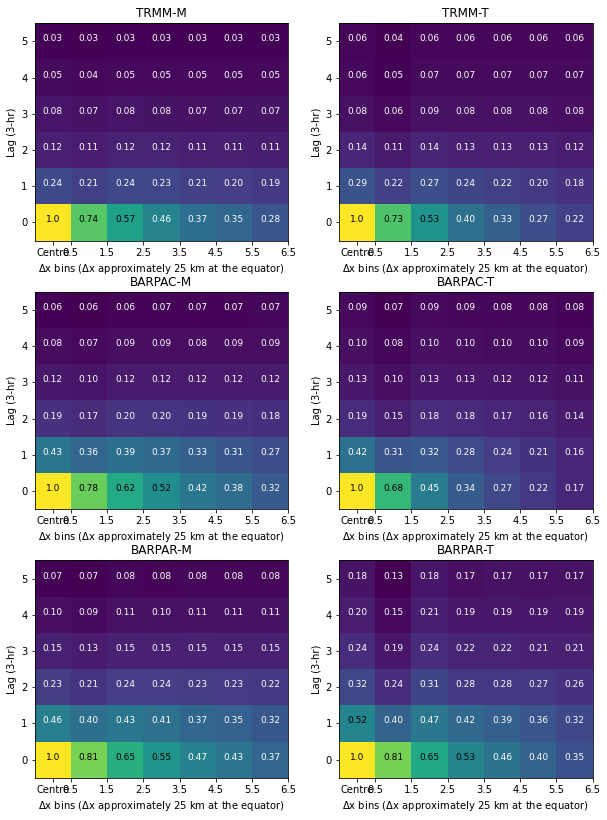

In [49]:
plt.figure(figsize=(10,14))
i=1
for model in ['TRMM-','BARPAC-','BARPAR-']:
    for region in ['M','T']:
        plot_equalgrid_corr(corr_map[model+region][0],corr_map[model+region][1],corr_map[model+region][2],corr_map[model+region][4],params[model+region],320+i)
        plt.title(model+region)
        i+=1

In [22]:
def plot_equalgrid_corr(corr_map,lag_vs_distance,autocorr,npts,model_dict,subplotnumber,title=True,colorbar=True,wk_dir='.',ext='.ps'):
    """
    corr_map,lag_vs_distance,autocorr,npts_map,npts
    Plots correlations as functions of space and time, which were first computed
    using compute_equalgrid_corr.

    Two types of plots are created:

        1. For each lag (from 0 to lag_length defined in model_dict), a 2D map
        of the composite correlations against the central point (at lag 0) for all
        points in the region (of length region_size).

        2. A single lag vs. distance plot showing the composite correlations against
        the central point (at lag 0), averaged over all points in each region in each
        distance bin (in steps of dx starting at 0.5dx), as well as the auto-correlation
        at the central point.

    See Fig. 2 in Klingaman et al. (2017, GMD, doi:10.5194/gmd-10-57-2017) for examples
    of these diagrams.

    Arguments:
      * corr_map (lag_length,region_size,region_size):
         Composite maps of correlations at each lag, returned from compute_equalgrid_corr
      * lag_vs_distance (lag_length,region_size):
         Composite correlations over all regions in the domain, expressed as a function of
         time (lag) and distance from the central point, returned from compute_equalgrid_corr
      * autocorr (lag_length):
         The composite auto-correlation of precipitation at the central point, averaged over
         all regions in the domain.
      * npts (lag_length,region_size):
         The number of gridpoints in each distance bin of the lag_vs_distance array.  Used to
         to determine whether there are any points in each distance bin.

    Optional arguments:
      * title:
         Include a title on the plot
      * colorbar:
         Include a colorbar on the plot

    Returns:
      None
    """

    region_size = model_dict['region_size']
    lag_length = model_dict['lag_length']

    print('---> Plotting correlation maps for '+str(region_size)+'x'+str(region_size)+' sub-regions')
    corr_con_levs=[0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95]

    # Plot correlation vs. distance diagram
    print('---> Plotting lag vs. distance diagram')
    plot_name=wk_dir+'/asop_coherence.'+model_dict['name']
    if 'grid_type' in model_dict:
        plot_name=plot_name+'_'+model_dict['grid_type']
    if 'time_type' in model_dict:
        plot_name=plot_name+'_'+model_dict['time_type']
    if 'region_name' in model_dict:
        plot_name=plot_name+'_'+model_dict['region_name'].replace(" ","_")
    plot_name=plot_name+'_precip_'+str(region_size)+'x'+str(region_size)+'_lag'+str(lag_length)+ext
#    cfp.setvars(file=plot_name,text_fontsize=20,axis_label_fontsize=18)
#    cfp.gopen(figsize=[9,8])
    ticklabels=['Centre','0.5']
    max_dist=0
    for dist in range(2,region_size):
        if npts[0,dist] > 0 :
            ticklabels.append(str(dist-0.5))
            max_dist=dist
    ticklabels.append(str(max_dist+0.5))
    ticklabels.append(str(max_dist+1.5))
    lag_vs_distance=np.insert(lag_vs_distance,0,autocorr,1)
#    cfp.gset(xmin=0,xmax=max_dist+1,ymin=0,ymax=lag_length)
#    cfp.levs(manual=np.array(corr_con_levs))
#    cfp.cscale(reverse=1,ncols=len(corr_con_levs)+1,white=0)
    xtickvals=np.arange(max_dist+1)+2.0
    xtickvals=np.insert(xtickvals,0,[0.5,1.0])
    plt.subplot(subplotnumber,aspect=1,xticks=xtickvals,yticks=np.arange(lag_length)+0.5,xticklabels=ticklabels,yticklabels=np.arange(lag_length),
             xlabel=r'$\Delta$x bins ($\Delta$x approximately '+str(round(model_dict['dx']))+' km at the equator)',
             ylabel='Lag (3-hr)')

    if title == True:
        title_string = 'Correlation map for '+model_dict['legend_name']
        if 'time_desc' in model_dict:
            title_string = title_string + ' - ' +model_dict['time_desc']
        if 'grid_desc' in model_dict:
            title_string = title_string + ' - ' +model_dict['grid_desc']
        if 'region_name' in model_dict:
            title_string = title_string+' - '+model_dict['region_name']
    else:
        title_string = ''
    if colorbar == True:
        print(lag_vs_distance.shape)
        plt.pcolormesh(np.arange(max_dist+2)+0.5,np.arange(lag_length)+0.5,lag_vs_distance[:,0:max_dist+2])#,,blockfill=1,
                #lines=False,line_labels=False,ptype=0,colorbar_title='Correlation with centre at lag=0, mean over all sub-regions',
                #title=title_string)

    else:
        plt.pcolormesh(np.arange(max_dist+2)+0.5,np.arange(lag_length)+0.5,lag_vs_distance[:,0:max_dist+2])#,blockfill=1,
                #lines=False,line_labels=False,ptype=0,colorbar=0,title=title_string)

    for dist in range(max_dist+2):
        for lag in range(lag_length):
            if lag_vs_distance[lag,dist] == -999:
                print('-999')
            #                cfp.plotvars.plot.text(dist+0.5,lag+0.5,'XXX',horizontalalignment='center',color='black',fontsize=20,verticalalignment='center')
            elif lag_vs_distance[lag,dist] > 0.5:
                plt.text(dist+0.5,lag+0.5,str(lag_vs_distance[lag,dist])[0:4],
                                       horizontalalignment='center',color='black',fontsize=9)
            elif lag_vs_distance[lag,dist] < 0.0:
                plt.text(dist+0.5,lag+0.5,str(lag_vs_distance[lag,dist])[0:5],
                                       horizontalalignment='center',color='black',fontsize=9)
            else:
                plt.text(dist+0.5,lag+0.5,str(lag_vs_distance[lag,dist])[0:4],
                                       horizontalalignment='center',color='white',fontsize=9)

    desc = {os.path.relpath(plot_name,wk_dir): {
        "longname": os.path.basename(plot_name).split(".")[1].replace("_"," "),
        "description": "Correlation vs distance diagram for lag "+str(lag)
        }
    }
#    update_output_json("plots",desc,wk_dir)

In [76]:
data['trmm'].summary(shorten=True)

'precipitation (mm/hr) / (unknown)   (year: 11; time: 720; latitude: 140; longitude: 60)'

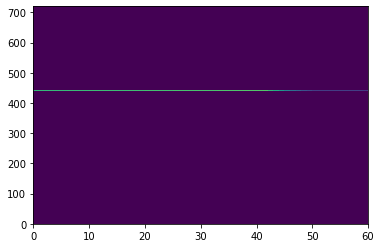

In [96]:
plt.pcolormesh(data['trmm'].data[0].mask.sum(axis=(1)))

In [24]:
data['trmm'].data=data['trmm'].data.filled(0)

In [106]:
data

{'BARPAC-M': <iris 'Cube' of stratiform_rainfall_flux / (mm/day) (year: 14; time: 720; latitude: 60; longitude: 60)>,
 'BARPAC-T': <iris 'Cube' of unknown / (1.15740740740741e-08 m.s-1) (year: 14; time: 720; latitude: 80; longitude: 60)>,
 'BARPA-E': <iris 'Cube' of precipitation_flux / (mm/day) (year: 14; time: 720; latitude: 140; longitude: 60)>,
 'trmm': <iris 'Cube' of precipitation (mm/hr) / (unknown) (year: 11; time: 720; latitude: 140; longitude: 60)>}

In [13]:
corr_map["BARPAC-"+region][i] + tmp1[i]

array([[[0.94086442, 1.04084047, 1.21024791, 1.36220706, 1.58309453,
         1.75372695, 1.80482258, 1.76799838, 1.73961776],
        [1.08110571, 1.17176775, 1.35164653, 1.6161319 , 1.94866395,
         2.08351071, 2.078605  , 2.02176201, 1.9092023 ],
        [1.22259362, 1.52172804, 1.814388  , 2.1606319 , 2.48388526,
         2.54582902, 2.4590396 , 2.22961636, 1.94774764],
        [1.66509371, 2.02198241, 2.40591672, 2.82294305, 3.16321858,
         3.20120139, 2.88188788, 2.42569593, 2.0275097 ],
        [1.88905502, 2.30738263, 2.79377056, 3.44274245, 4.        ,
         3.38565054, 2.72394436, 2.16447344, 1.73972567],
        [2.05099605, 2.43932766, 2.7619299 , 3.06881224, 2.97459676,
         2.53855956, 2.17735553, 1.85902265, 1.50066319],
        [2.02767204, 2.25916241, 2.3972381 , 2.41986796, 2.28259955,
         2.06409587, 1.81034762, 1.52827993, 1.2448303 ],
        [1.85288061, 1.99954633, 2.0246461 , 1.94046331, 1.83164394,
         1.70073728, 1.45915745, 1.2398720

In [11]:
data

{'BARPAC-M': <iris 'Cube' of stratiform_rainfall_flux / (mm/day) (year: 20; time: 720; latitude: 60; longitude: 60)>,
 'BARPAC-T': <iris 'Cube' of stratiform_rainfall_flux / (mm/day) (year: 20; time: 720; latitude: 80; longitude: 60)>,
 'BARPA-E': <iris 'Cube' of precipitation_flux / (mm/day) (year: 20; time: 720; latitude: 140; longitude: 60)>,
 'trmm': <iris 'Cube' of precipitation (mm/hr) / (unknown) (year: 11; time: 720; latitude: 140; longitude: 60)>}

In [36]:
corr_map["BARPAC-T"][0].max()*11**3

1.0